In [1]:
import json
import os

# Assuming all JSON files are in the 'json_directory'
json_directory = r'DeepFashion2\train\train\annos'
category_names = {}

# Loop through each file in the directory
for filename in os.listdir(json_directory):
    if filename.endswith('.json'):
        file_path = os.path.join(json_directory, filename)
        with open(file_path, 'r') as file:
            data = json.load(file)
            # Check if the conditions are met (viewpoint and zoom_in)
            if 'item1' in data and data['item1'].get('viewpoint') in [2, 3] and data['item1'].get('zoom_in') == 1:
                # Extract the category_name for item1
                category_name = data['item1'].get('category_name')
                if category_name:
                    # Count occurrences of each category_name
                    if category_name in category_names:
                        category_names[category_name] += 1
                    else:
                        category_names[category_name] = 1

# Print out the counts for each category_name
for category, count in category_names.items():
    print(f'Category: {category}, Count: {count}')


KeyboardInterrupt: 

In [11]:
import json
import cv2
import os
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import open3d as o3d
import sys
import tkinter as tk
from tkinter import filedialog
import numpy as np
import trimesh
import meshlib.mrmeshpy as mr

In [2]:
def depth_map_to_point_cloud(depth_map):
    """
    Convert a depth map to a 3D point cloud.

    Args:
        depth_map (numpy.ndarray): The depth map.

    Returns:
        numpy.ndarray: The 3D point cloud.
    """
    """
    image_height = depth_map.shape[0]
    image_width = depth_map.shape[1]

    # Convert FOV from degrees to radians
    fov_horizontal_rad = np.deg2rad(60)

    # Calculate focal length in pixels
    focal_length_x = image_width / (2 * np.tan(fov_horizontal_rad / 2))

    # If the aspect ratio is 1:1
    focal_length_y = focal_length_x

    # If the aspect ratio is not 1:1, calculate the vertical FOV
    # aspect_ratio = image_width / image_height
    # fov_vertical_rad = 2 * np.arctan(np.tan(fov_horizontal_rad / 2) / aspect_ratio)
    # focal_length_y = image_height / (2 * np.tan(fov_vertical_rad / 2))

    # Calculate optical centers
    center_x = image_width / 2
    center_y = image_height / 2
    """
    
    center_x = depth_map.shape[1] // 2
    center_y = depth_map.shape[0] // 2

    # Create a grid of (x, y) coordinates corresponding to each pixel
    x, y = np.meshgrid(np.arange(depth_map.shape[1]), np.arange(depth_map.shape[0]))
    
    # Normalize (x, y) coordinates to the camera coordinates
    x = (x - center_x)
    y = (y - center_y)
    
    # Unproject
    # z keeps the original depth values, x and y are reprojected
    z = depth_map
    #x = x * z
    #y = y * z
    
    # Stack to create 3D point cloud
    point_cloud = np.dstack((x, y, z)).reshape(-1, 3)
    
    return point_cloud

Using cache found in C:\Users\hartda23/.cache\torch\hub\intel-isl_MiDaS_master
Downloading: "https://github.com/isl-org/MiDaS/releases/download/v3/dpt_large_384.pt" to C:\Users\hartda23/.cache\torch\hub\checkpoints\dpt_large_384.pt
100%|██████████████████████████████████████████████████████████████████████████████████████████| 1.28G/1.28G [00:56<00:00, 24.4MB/s]
Using cache found in C:\Users\hartda23/.cache\torch\hub\intel-isl_MiDaS_master


(658, 468)
307944


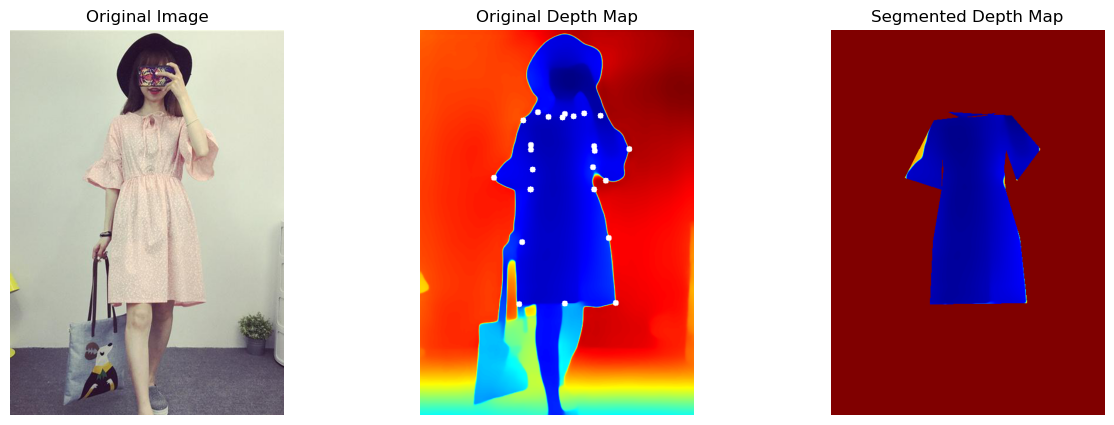

True

In [3]:
# Allowed categories for tops and dresses
allowed_categories = ["short sleeve top", "long sleeve top", "vest dress", "long sleeve dress", "short sleeve dress", "sling", "sling dress"]

# Original JSON file path
json_file_path = 'DeepFashion2/train/train/annos/000259.json'

# Define output directories
depth_map_dir = r"outs/Depth Map Output PNG"
ply_output_dir = r"outs/PLY output"
mesh_output_dir = r"outs/mesh output"
segmented_depth_map_dir = r"outs/segment map"

# Ensure directories exist
os.makedirs(depth_map_dir, exist_ok=True)
os.makedirs(ply_output_dir, exist_ok=True)
os.makedirs(mesh_output_dir, exist_ok=True)
os.makedirs(segmented_depth_map_dir, exist_ok=True)

# Extract the base filename without the extension
base_filename = os.path.splitext(os.path.basename(json_file_path))[0]

with open(json_file_path, 'r') as file:
    json_data = json.load(file)

# Image path 
image_path = os.path.join('DeepFashion2/train/train/image', base_filename + '.jpg') 
img = np.array(Image.open(image_path))

# Check conditions
if json_data['item1']['zoom_in'] != 1 or json_data['item1']['viewpoint'] not in [2, 3]:
    print("Conditions not met. Skipping this file.")
    sys.exit()  # Stop the process

keypoints_data = {}
for item_key, item_value in json_data.items():
    if isinstance(item_value, dict) and 'landmarks' in item_value and item_value['category_name'] in allowed_categories:  # Check if it's a dictionary, has 'landmarks', and is an allowed category
        keypoints = item_value['landmarks']
        keypoints_data[item_value['category_name']] = [(keypoints[i], keypoints[i + 1]) for i in range(0, len(keypoints), 3) if keypoints[i + 2] > 0]

# Now, `keypoints_data` contains keypoints organized by category name, hopefully

# Extract the base name of the file and remove the extension to get the number
file_number = os.path.splitext(os.path.basename(image_path))[0]

# Load  MiDaS model
midas_model_type = "DPT_Large" 
midas = torch.hub.load("intel-isl/MiDaS", midas_model_type)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
midas.to(device)
midas.eval()

# Load MiDaS transforms
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
transform = midas_transforms.dpt_transform if midas_model_type in ["DPT_Large", "DPT_Hybrid"] else midas_transforms.small_transform

# Apply MiDaS transforms to image
input_batch = transform(img).to(device)

# Get depth map
with torch.no_grad():
    depth_prediction = midas(input_batch)
    depth_prediction = torch.nn.functional.interpolate(
        depth_prediction.unsqueeze(1),
        size=img.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

# Convert depth map to a NumPy array
depth_map = depth_prediction.cpu().numpy()

# Normalize the depth map + apply color map / keypoints to depth map
depth_map_normalized = cv2.normalize(depth_map, None, 0, 255, cv2.NORM_MINMAX)
depth_map_visual = cv2.applyColorMap(depth_map_normalized.astype('uint8'), cv2.COLORMAP_JET)
for category, keypoints in keypoints_data.items():
    for x, y in keypoints:
        # white color for keypoints, change color if needed
        cv2.circle(depth_map_visual, (int(x), int(y)), 5, (255, 255, 255), -1)

# After converting the depth map to a NumPy array
print(depth_map.shape)
print(np.count_nonzero(depth_map))

# Extract keypoints for 'item1' which represents the shirt
shirt_keypoints = []
if 'item1' in json_data and 'landmarks' in json_data['item1']:
    keypoints = json_data['item1']['landmarks']
    shirt_keypoints = [(keypoints[i], keypoints[i + 1]) for i in range(0, len(keypoints), 3) if keypoints[i + 2] > 0]

# Check if shirt keypoints were found
if not shirt_keypoints:
    print("No shirt keypoints found. Skipping this file.")
    sys.exit()

# Create the segmentation mask for the shirt
mask = np.zeros_like(depth_map, dtype=np.uint8)  # Use the original depth map's shape for mask creation
poly = np.array([shirt_keypoints], dtype=np.int32)
cv2.fillPoly(mask, poly, 255)  # Fill with white where the shirt is

# Apply the mask to the depth map to segment the shirt
segmented_depth_map = cv2.bitwise_and(depth_map, depth_map, mask=mask)

# Now scale the segmented depth map
segmented_depth_map_scaled = segmented_depth_map * 30  # Adjust the scaling factor as needed

# Visualize the original image, original depth map, and segmented depth map for comparison
plt.figure(figsize=(15, 5))

# Original image visualization
plt.subplot(1, 3, 1)
plt.imshow(img)
plt.title('Original Image')
plt.axis('off')

# Original depth map visualization
plt.subplot(1, 3, 2)
plt.imshow(depth_map_visual)
plt.title('Original Depth Map')
plt.axis('off')

# Segmented and scaled depth map visualization
segmented_depth_map_visual = cv2.normalize(segmented_depth_map_scaled, None, 0, 255, cv2.NORM_MINMAX)
segmented_depth_map_visual = cv2.applyColorMap(segmented_depth_map_visual.astype('uint8'), cv2.COLORMAP_JET)
plt.subplot(1, 3, 3)
plt.imshow(segmented_depth_map_visual)
plt.title('Segmented Depth Map')
plt.axis('off')
plt.show()

file_number = os.path.splitext(os.path.basename(image_path))[0]
segment_file = os.path.join(segmented_depth_map_dir, f"{file_number}_segment.png")
depth_map_file = os.path.join(depth_map_dir, f"{base_filename}_depth_map.png")

# Save the depth map image
cv2.imwrite(depth_map_file, depth_map_visual)

# Save the segment map visual
cv2.imwrite(segment_file, segmented_depth_map_visual)

In [4]:
# Create a PointCloud object from Open3D
points_3d = depth_map_to_point_cloud(segmented_depth_map_scaled)
point_cloud_o3d = o3d.geometry.PointCloud()
points_3d = np.asarray(points_3d)
points_3d[:, 1] = -points_3d[:, 1]  # Flip the y-coordinates
point_cloud_o3d.points = o3d.utility.Vector3dVector(points_3d)

# After creating the point cloud
print(np.asarray(point_cloud_o3d.points).shape)

ply_file = os.path.join(ply_output_dir, f"{file_number}_point_cloud.ply")

# Save the point cloud
o3d.io.write_point_cloud(ply_file, point_cloud_o3d)

# Visualize the point cloud
o3d.visualization.draw_geometries([point_cloud_o3d])

(307944, 3)


In [5]:
# Estimate normals for the point cloud
point_cloud_o3d.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))

# Apply Poisson Surface Reconstruction
poisson_mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(point_cloud_o3d, depth=9)[0]

# Compute the vertices' normals
poisson_mesh.compute_vertex_normals()

# Compute the distance of each vertex from the camera
distances = np.linalg.norm(np.asarray(poisson_mesh.vertices), axis=1)

# Normalize the distances to the range [0, 1]
distances_normalized = (distances - distances.min()) / (distances.max() - distances.min())

# Create a colormap based on the distances
colors = plt.cm.viridis(distances_normalized)

# Set the color of each vertex
poisson_mesh.vertex_colors = o3d.utility.Vector3dVector(colors[:, :3])

# Visualize the mesh
o3d.visualization.draw_geometries([poisson_mesh])

# Use the file number when saving the output files
mesh_file = os.path.join(mesh_output_dir, f"{file_number}_mesh.obj")

# Save the mesh
o3d.io.write_triangle_mesh(mesh_file, poisson_mesh)

[Open3D WARNING] Write OBJ can not include triangle normals.


True

In [47]:
# Convert (x, y) keypoints to 3D by adding a z-coordinate
shirt_keypoints_3d = [(x, y, 0) for x, y in shirt_keypoints]

# Convert shirt_keypoints to numpy array
keypoints_np = np.array(shirt_keypoints_3d)

# Load the saved mesh
mesh = mr.loadMesh(mesh_file)

# Find closest point on mesh
projected_points = []
for i in range(len(keypoints_np)):
    p = mr.Vector3f()
    p.x = keypoints_np[i,0]
    p.y = keypoints_np[i,1]
    p.z = keypoints_np[i,2]
    
    values = mr.findProjection(p, mesh)

    #print(values.distSq)
    #print(values.mtp)
    #print(values.proj.point.x)
    
    projected_points.append(values.mtp)

# Calculate the geodesic distances between the closest vertices
num_points = len(projected_points)
geo_dists = np.zeros((num_points,num_points))
for i in range(num_points):
    for j in range(num_points):
        if i == j:
            continue
        
        surf_path = mr.computeGeodesicPath(mesh,projected_points[i],projected_points[j],mr.GeodesicPathApprox.FastMarching)

        print(help(surf_path))
        
        dist = mr.surfacePathLength(mesh,surf_path)
        
        #print(dist)

        geo_dists[i,j] = dist
        


Help on SurfacePath in module meshlib.mrmeshpy object:

class SurfacePath(pybind11_builtins.pybind11_object)
 |  Method resolution order:
 |      SurfacePath
 |      pybind11_builtins.pybind11_object
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __bool__(...)
 |      __bool__(self: meshlib.mrmeshpy.SurfacePath) -> bool
 |      
 |      Check whether the list is nonempty
 |  
 |  __contains__(...)
 |      __contains__(self: meshlib.mrmeshpy.SurfacePath, x: meshlib.mrmeshpy.EdgePoint) -> bool
 |      
 |      Return true the container contains ``x``
 |  
 |  __delitem__(...)
 |      __delitem__(*args, **kwargs)
 |      Overloaded function.
 |      
 |      1. __delitem__(self: meshlib.mrmeshpy.SurfacePath, arg0: int) -> None
 |      
 |      Delete the list elements at index ``i``
 |      
 |      2. __delitem__(self: meshlib.mrmeshpy.SurfacePath, arg0: slice) -> None
 |      
 |      Delete list elements using a slice object
 |  
 |  __eq__(...)
 |      __eq__(self: me

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [19]:
funcs = dir (mr)
for f in funcs:
    if not f.startswith('_'):
        print( help( "mrmeshpy." + f))
        print()

No Python documentation found for 'mrmeshpy.AABBTreePolyline2'.
Use help() to get the interactive help utility.
Use help(str) for help on the str class.

None

No Python documentation found for 'mrmeshpy.AABBTreePolyline3'.
Use help() to get the interactive help utility.
Use help(str) for help on the str class.

None

No Python documentation found for 'mrmeshpy.AffineXf2d'.
Use help() to get the interactive help utility.
Use help(str) for help on the str class.

None

No Python documentation found for 'mrmeshpy.AffineXf2f'.
Use help() to get the interactive help utility.
Use help(str) for help on the str class.

None

No Python documentation found for 'mrmeshpy.AffineXf3d'.
Use help() to get the interactive help utility.
Use help(str) for help on the str class.

None

No Python documentation found for 'mrmeshpy.AffineXf3f'.
Use help() to get the interactive help utility.
Use help(str) for help on the str class.

None

No Python documentation found for 'mrmeshpy.BooleanOperation'.
Use h

In [7]:
# B spline - 
# Geodesic Distance

# find locations on the mesh that maps to these

pip install

ModuleNotFoundError: No module named 'igl'